In [1]:
#---------------------------------------------------------------------------------------------GENERAL-----------------------------------------------------------------------------------------------
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import VOCDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.multiprocessing as mp
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from typing import Dict
import numpy as np
from torch.utils.data import Dataset
import os
from PIL import Image
import xml.etree.ElementTree as ET
import collections
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn as nn
import torchviz
from torchsummary import summary
import pytesseract
import re
import cv2  
import easyocr
import keras_ocr
import math
from datetime import datetime

# Specify Tesseract path (example for Windows)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

#-------------------------------------------------------------------------------------JUPYTER NOTEBOOK SETTINGS-------------------------------------------------------------------------------------
from IPython.core.display import display, HTML                                    
display(HTML("<style>.container { width:100% !important; }</style>"))     

C:\Users\Ciprian-Florin Ifrim\AppData\Local\Temp\ipykernel_23496\3545565238.py:48: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Load the pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# Replace the classifier with a new one
num_classes = 6
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Put model to device
device = torch.device('cpu')
model.to(device)

# Load saved model
model.load_state_dict(torch.load('pytorch_rcnn_models/FINAL-v2_rcnn_batch-16_epoch-40_full-enchanced-original_non-augmented.pt'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [3]:
# Data processing
data_transforms = transforms.Compose([
    transforms.Resize(512),                                            
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999])


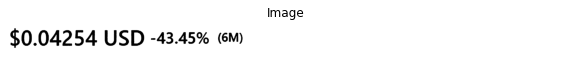

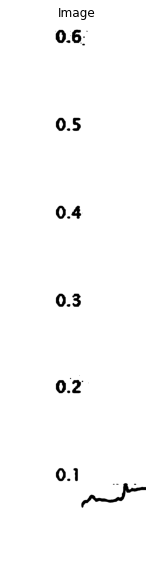

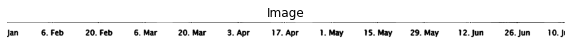

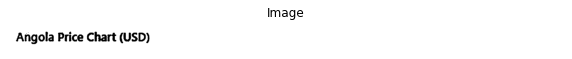

{'value': 'S0.04254 USD -43.45%,(6M)', 'y-axis': '0.6:,0.5,0.4,0.3,0.2,0.1', 'x-axis': 'Jan,6. Feb,20. Feb,6. Mar,20.,Mar,3. Apr,17. Apr,1 . May,15. May,29. May,12. Jun,26. Jun,10. Jo', 'name': 'Angola Price Chart (USD)'}


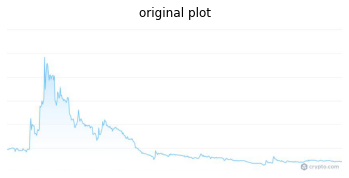

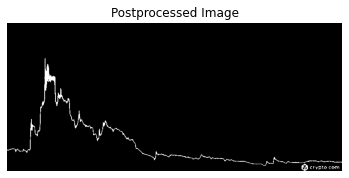

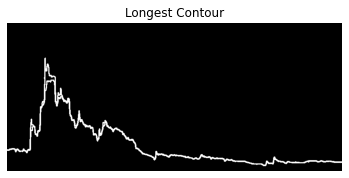

Lowest Pixel Coordinates: [640 356]
Highest Pixel Coordinates: [95 89]
Right-Most Pixel Coordinates: [835 348]


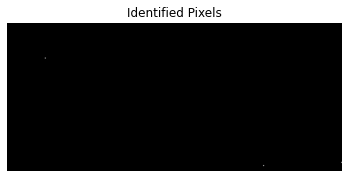

New Y-axis values: [0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
New Y coordinates: [13, 71, 129, 189, 247, 305, 363]


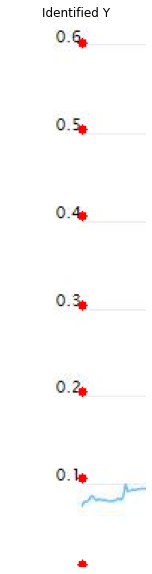

The Y-axis value for the Y coordinate 348 is 0.02586
The stock value from the plot is 0.04254
The percentage difference is 39.21%
0.0017123287671232878
Curve value based on secondaly calculation is 0.037671232876712334
The percentage difference is 11.445%


In [8]:
image_path = 'pascal_voc_datasets/VOCdevkit/PlotsEnchanced_Original_NoAugmentation/JPEGImages/'
img_name = 'image304'
CUSTOM_CLASSES = {"name": 1, "value": 2, "x-axis": 3, "y-axis": 4, "plot":5}

img = Image.open(image_path + img_name + '.jpg')
orig_width, orig_height = img.size                                   # Store the original image dimensions

# Process the image
img_processed = data_transforms(img)

# Calculate the scale ratios
new_width, new_height = img_processed.shape[1], img_processed.shape[2]

# Calculate the scale ratios
if orig_width <= orig_height:
    new_height = 512
    new_width = int(orig_width * (new_height / orig_height))
else:
    new_width = 512
    new_height = int(orig_height * (new_width / orig_width))
    
width_ratio = new_width / orig_width
height_ratio = new_height / orig_height

with torch.no_grad():
    prediction = model([img_processed])

# Scale bounding boxes back to original image size
for box in prediction[0]['boxes']:
    box[0] *= (1 / width_ratio)
    box[2] *= (1 / width_ratio)
    box[1] *= (1 / height_ratio)
    box[3] *= (1 / height_ratio)

# Debugging
#print(prediction[0]['boxes'])
print(prediction[0]['scores'])


results = {}                                 # Dictionary to store the results
yaxis_coordinates = []                       # Initialize a list to store the Y coordinates
label5_image = None                          # Variable to store the cropped image for label 5
y_axis_image = None

reader = easyocr.Reader(lang_list=['en'])       # Create a reader to recognize the English language

for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if label >= 1 and label <= 4 and score > 0.7:                                                 # Check if the score is above 0.7 and label is between 1 and 4
        xmin, ymin, xmax, ymax = [int(i) for i in box]                                            # Convert box coordinates to integers
        cropped_image = img.crop((xmin, ymin, xmax, ymax))                                        # Crop the image          
        bw_img = cropped_image.convert("L")                                                       # Convert the cropped image to grayscale (black and white)
        bw_img_array = np.array(bw_img)

        # Resize the image (e.g., double the size)
        resized_img = cv2.resize(bw_img_array, (0,0), fx=8, fy=8, interpolation = cv2.INTER_CUBIC)

        # Contrast Enhancement
        clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(16, 16))
        enhanced_img = clahe.apply(resized_img)

        # Apply Otsu's thresholding
        _, thresh_img = cv2.threshold(enhanced_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Assuming resized_img has been defined as in your snippet
        plt.figure(figsize=(10, 10))
        plt.imshow(thresh_img, cmap='gray')
        plt.title('Image')
        plt.axis('off')  # To turn off the axis
        plt.show()
        
        if label == CUSTOM_CLASSES["y-axis"]:
            y_axis_image = cropped_image
            
            result = reader.readtext(thresh_img)
            text_results = [item[1] for item in result]                            # Extract only the text
            text_found = ','.join(text_results)
            
            for (bbox, text, prob) in result:
                bottom_y1 = bbox[1][1]  # Get the y-coordinate of one of the bottom points
                bottom_y2 = bbox[2][1]  # Get the y-coordinate of the other bottom point
                #print(bottom_y1, bottom_y2)
                average_y = (bottom_y1 + bottom_y2) / 2  # Calculate the average y-coordinate
                quarter_y = (bottom_y2 + average_y) / 2
                yaxis_coordinates.append(int(quarter_y / 8))  # Add the average y-coordinate for each text box available (divide by the upscale factor)
        else:
            result = reader.readtext(thresh_img, detail = 0)      
            text_found = ','.join(result)
            text_found = re.sub('\n+', ',', text_found)                                           # Replace one or more consecutive newline characters with a single comma
            
                                                                  
        label_name = [name for name, id in CUSTOM_CLASSES.items() if id == label][0]              # Find the label name using the CUSTOM_CLASSES dictionary
        results[label_name] = text_found                                                                # Store the result in the dictionary
        
    elif label == 5 and score > 0.8:                                                              # Check if the label is 5 and the score is above 0.7
        xmin, ymin, xmax, ymax = [int(i) for i in box]                                            # Convert box coordinates to integers
        label5_image = img.crop((xmin, ymin, xmax, ymax))                                         # Crop the image for label 5

# The results dictionary now contains the extracted text for labels 1 to 4
print(results)

#############################################################################################################################
plt.imshow(label5_image)
plt.title("original plot")
plt.axis('off')
plt.show()
    
# Plot processing
bw_label5_img = label5_image.convert("L")                                                       # Convert the cropped image to grayscale (black and white)
bw_label5_img_array = np.array(bw_label5_img)

# Apply Gaussian blur to reduce noise and improve the result of Canny edge detection
blurred_label5_img = cv2.GaussianBlur(bw_label5_img_array, (3, 3), 0)

# First, apply a binary threshold on the image
_, thresh_label5_img = cv2.threshold(blurred_label5_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

inverted_label5_img = cv2.bitwise_not(thresh_label5_img)

# Define a kernel for the erosion (a 3x3 square is common)
kernel = np.ones((2,2), np.uint8)
eroded_label5_img = cv2.erode(inverted_label5_img, kernel, iterations = 1)                  # Apply the erosion
closed_label5_img = cv2.morphologyEx(eroded_label5_img, cv2.MORPH_CLOSE, kernel)

plt.imshow(closed_label5_img, cmap='gray')
plt.title('Postprocessed Image')
plt.axis('off')
plt.show()

######################################################################################################################
# Find the contours
contours, hierarchy = cv2.findContours(closed_label5_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the perimeter for each contour and find the index of the longest one
max_length = 0
longest_contour_index = 0
for i, contour in enumerate(contours):
    length = cv2.arcLength(contour, True) # The 'True' argument indicates that the contour is closed
    if length > max_length:
        max_length = length
        longest_contour_index = i
        
# Extract the longest contour
longest_contour = contours[longest_contour_index]
        
# Create a blank image to draw the longest contour
output_image = np.zeros_like(closed_label5_img)

# Draw the longest contour on the output image
cv2.drawContours(output_image, [longest_contour], -1, (255, 255, 255), 2)

# Show the image with the drawn contour using Matplotlib
plt.imshow(output_image, cmap='gray')
plt.title('Longest Contour')
plt.axis('off')
plt.show()


######################################################################################################################
# Find the lowest, highest, and right-most pixels
lowest_pixel = longest_contour[longest_contour[:, :, 1].argmax()][0]
highest_pixel = longest_contour[longest_contour[:, :, 1].argmin()][0]

right_most_pixels = longest_contour[longest_contour[:, :, 0].argmax()]                   # Find the right-most pixels
right_most_pixel = min(right_most_pixels, key=lambda x: x[1])                            # Then find the one with the lowest Y value among them

# Print the coordinates
print("Lowest Pixel Coordinates:", lowest_pixel)
print("Highest Pixel Coordinates:", highest_pixel)
print("Right-Most Pixel Coordinates:", right_most_pixel)

# Create a blank image to draw the identified pixels
pixel_image = np.zeros_like(closed_label5_img)

# Draw the identified pixels on the blank image using a white color (255)
cv2.circle(pixel_image, lowest_pixel, radius=1, color=255, thickness=-1)
cv2.circle(pixel_image, highest_pixel, radius=1, color=255, thickness=-1)
cv2.circle(pixel_image, right_most_pixel, radius=1, color=255, thickness=-1)

# Show the image with the drawn pixels using Matplotlib
plt.imshow(pixel_image, cmap='gray')
plt.title('Identified Pixels')
plt.axis('off')
plt.show()

######################################################################################################################
# this function finds the average difference between all the elements in a list, then adds a new element at the end
# equal to the last element minus the average
def calculate_new_list(lst):
    # Calculate the differences between successive elements
    differences = [lst[i] - lst[i + 1] for i in range(len(lst) - 1)]
    
    # Calculate the average difference
    avg_difference = sum(differences) / len(differences)
    
    # Add a new element at the end of the list
    new_element = lst[-1] - avg_difference 
    lst.append(new_element)

    return lst

def extract_currency(string):
    # Dictionary to map symbols to currency names
    currency_map = {
        '$': 'USD',
        '€': 'EUR',
        '£': 'GBP',
        '¥': 'JPY',
        'A$': 'AUD',
        'C$': 'CAD',
        # You can add more currency symbols and their respective codes here
    }
    
    # Use a regular expression to find any of the currency symbols or abbreviations
    pattern = re.compile(r'\$|€|£|¥|A\$|C\$|USD|EUR|GBP|JPY|AUD|CAD')
    match = pattern.search(string)
    
    if match:
        symbol = match.group()
        # Map the symbol to the currency code if it exists in the dictionary
        return currency_map.get(symbol, symbol).lower()
    else:
        return None

def extract_percentage(string):
    match = re.search(r'([-+]?\d+\.\d+)\s*%', string)
    if match:
        percentage = float(match.group(1))
        return percentage
    return None

def extract_bracketed_timeframe(string):
    match = re.search(r'\(([^)]+)\)', string)
    if match:
        bracketed_string = match.group(1)
        return bracketed_string.lower()
    return None

def extract_float_value(input_string):
    numbers = re.findall(r'\d+\.\d+', input_string)                                      # Find all the floating-point numbers in the string using a regular expression
    return float(numbers[0])                                                             # Return the first floating-point number found, as a float

######################################################################################################################
# DRAWING THE Y-AXIS DATA LOCATION ON THE IMAGE
# Apply the function to both lists
y_axis_str = results['y-axis']
y_axis_values = [extract_float_value(value) for value in y_axis_str.split(',')]

y_axis_values_new = calculate_new_list(y_axis_values)
yaxis_coordinates_new = calculate_new_list(yaxis_coordinates)
yaxis_coordinates_new = list(map(round, yaxis_coordinates_new))

print("New Y-axis values:", y_axis_values_new)
print("New Y coordinates:", yaxis_coordinates_new)

y_axis_image = np.array(y_axis_image)
for i,item in enumerate(yaxis_coordinates_new):
    # Draw the identified pixels
    x, y = 50, int(item)
    cv2.circle(y_axis_image, (x, y), radius=3, color=255, thickness=-1)

# Show the image with the drawn pixels using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(y_axis_image)
plt.title('Identified Y')
plt.axis('off')
plt.show()

######################################################################################################################
# FIRST INTERPOLATION METHOD
# Value interpolation from curve
from scipy.interpolate import interp1d

# Create a linear interpolation function
f = interp1d(yaxis_coordinates_new, y_axis_values_new)

# Example usage
type1_interp_current_val = round(float(f(right_most_pixel[1])), 5)
print(f"The Y-axis value for the Y coordinate {right_most_pixel[1]} is {type1_interp_current_val}")

# value from plot
value_str = results['value']
stock_value = extract_float_value(value_str)
print(f"The stock value from the plot is {stock_value}")

# value difference/accuracy
type1_pct_diff = round(((stock_value - type1_interp_current_val) / stock_value) * 100, 3)
print(f"The percentage difference is {type1_pct_diff:.2f}%")

######################################################################################################################
# SECOND INTERPOLATION METHOD
y_axis_val_diff = abs(y_axis_values[-1] - y_axis_values[0])
y_axis_coord_dif = abs(yaxis_coordinates[-1] - yaxis_coordinates[0])
y_axis_val_per_pixel = y_axis_val_diff/y_axis_coord_dif

print(y_axis_val_per_pixel)

plot_height = label5_image.height
type2_interp_current_val = (abs(plot_height - right_most_pixel[1])) * y_axis_val_per_pixel

print(f"Curve value based on secondaly calculation is {type2_interp_current_val}")

# value from plot
type2_pct_diff = round(((stock_value - type2_interp_current_val) / stock_value) * 100, 3)
print(f"The percentage difference is {type2_pct_diff:.3f}%")
######################################################################################################################
# Compare the 2 methods and choose the one with the lowest percentage difference
if type1_pct_diff < type2_pct_diff:
    lowest_value  = round(float(f(lowest_pixel[1])), 5)
    highest_value = round(float(f(highest_pixel[1])), 5)
else:
    lowest_value  = (abs(plot_height - lowest_pixel[1])) * y_axis_val_per_pixel
    highest_value = (abs(plot_height - highest_pixel[1])) * y_axis_val_per_pixel

######################################################################################################################
# Extracting all the other values
# Define the observations
data = {
    'name': results['name'].split(" Price")[0],
    'currency': extract_currency(results['value']),
    'value.pct.drop': extract_percentage(results['value']),
    'current.value': stock_value,
    'type1.interp.current.value': type1_interp_current_val,
    'type2.interp.current.value': type2_interp_current_val,
    'type1.curr.val.pct.diff': type1_pct_diff,
    'type2.curr.val.pct.diff': type2_pct_diff,
    'lowest.value': lowest_value,
    'highest.value': highest_value,
    'timeframe': extract_bracketed_timeframe(results['value']),
    'date': datetime.now().date(),
    'time': datetime.now().time().strftime('%H:%M:%S')                            # Format the time properly
}

# Create a DataFrame
df = pd.DataFrame(data, index = [0])

# Saving the DataFrame to a CSV file
dataset_path = "datasets/dataset.csv"
df.to_csv(dataset_path, index=False)

In [ ]:
# KERAS-OCR TEST 
image_path = 'pascal_voc_datasets/VOCdevkit/PlotsEnchanced_Original_NoAugmentation/JPEGImages/'
img_name = 'image117687'
CUSTOM_CLASSES = {"name": 1, "value": 2, "x-axis": 3, "y-axis": 4, "plot":5}

img = Image.open(image_path + img_name + '.jpg')
orig_width, orig_height = img.size                                   # Store the original image dimensions

# Process the image
img_processed = data_transforms(img)

# Calculate the scale ratios
new_width, new_height = img_processed.shape[1], img_processed.shape[2]

# Calculate the scale ratios
if orig_width <= orig_height:
    new_height = 512
    new_width = int(orig_width * (new_height / orig_height))
else:
    new_width = 512
    new_height = int(orig_height * (new_width / orig_width))
    
width_ratio = new_width / orig_width
height_ratio = new_height / orig_height

with torch.no_grad():
    prediction = model([img_processed])

# Scale bounding boxes back to original image size
for box in prediction[0]['boxes']:
    box[0] *= (1 / width_ratio)
    box[2] *= (1 / width_ratio)
    box[1] *= (1 / height_ratio)
    box[3] *= (1 / height_ratio)

# Debugging
#print(prediction[0]['boxes'])
print(prediction[0]['scores'])


# Create a recognition pipeline
pipeline = keras_ocr.pipeline.Pipeline()

results = {}                                 # Dictionary to store the results
label5_image = None                          # Variable to store the cropped image for label 5

for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if label >= 1 and label <= 4 and score > 0.7:
        xmin, ymin, xmax, ymax = [int(i) for i in box]
        cropped_image = img.crop((xmin, ymin, xmax, ymax))
        cropped_image_array = np.array(cropped_image)

        plt.figure(figsize=(10, 10))
        plt.imshow(thresh_img, cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.show()

        result = pipeline.recognize([cropped_image_array])[0]
        text = ','.join([word[0] for word in result])
        text = re.sub('\n+', ',', text)
        label_name = [name for name, id in CUSTOM_CLASSES.items() if id == label][0]
        results[label_name] = text
        
    elif label == 5 and score > 0.8:
        xmin, ymin, xmax, ymax = [int(i) for i in box]
        label5_image = img.crop((xmin, ymin, xmax, ymax))

print(results)

In [ ]:
# PYTESSERACT OCR TESTING
image_path = 'pascal_voc_datasets/VOCdevkit/PlotsEnchanced_Original_NoAugmentation/JPEGImages/'
img_name = 'image1'
CUSTOM_CLASSES = {"name": 1, "value": 2, "x-axis": 3, "y-axis": 4, "plot":5}

img = Image.open(image_path + img_name + '.jpg')
orig_width, orig_height = img.size                                   # Store the original image dimensions

# Process the image
img_processed = data_transforms(img)

# Calculate the scale ratios
new_width, new_height = img_processed.shape[1], img_processed.shape[2]

# Calculate the scale ratios
if orig_width <= orig_height:
    new_height = 512
    new_width = int(orig_width * (new_height / orig_height))
else:
    new_width = 512
    new_height = int(orig_height * (new_width / orig_width))
    
width_ratio = new_width / orig_width
height_ratio = new_height / orig_height

with torch.no_grad():
    prediction = model([img_processed])

# Scale bounding boxes back to original image size
for box in prediction[0]['boxes']:
    box[0] *= (1 / width_ratio)
    box[2] *= (1 / width_ratio)
    box[1] *= (1 / height_ratio)
    box[3] *= (1 / height_ratio)

# Debugging
#print(prediction[0]['boxes'])
print(prediction[0]['scores'])


results = {}                                 # Dictionary to store the results
label5_image = None                          # Variable to store the cropped image for label 5

for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if label >= 1 and label <= 4 and score > 0.7:                                                 # Check if the score is above 0.7 and label is between 1 and 4
        xmin, ymin, xmax, ymax = [int(i) for i in box]                                            # Convert box coordinates to integers
        cropped_image = img.crop((xmin, ymin, xmax, ymax))                                        # Crop the image
        bw_img = cropped_image.convert("L")                                                       # Convert the cropped image to grayscale (black and white)
        bw_img_array = np.array(bw_img)

        # Resize the image (e.g., double the size)
        resized_img = cv2.resize(bw_img_array, (0,0), fx=2, fy=2, interpolation = cv2.INTER_CUBIC)

        # Contrast Enhancement
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(32, 32))
        enhanced_img = clahe.apply(resized_img)

        # Apply Otsu's thresholding
        _, thresh_img = cv2.threshold(enhanced_img, 200, 30, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Assuming resized_img has been defined as in your snippet
        plt.figure(figsize=(10, 10))
        plt.imshow(thresh_img, cmap='gray')
        plt.title('Image')
        plt.axis('off')  # To turn off the axis
        plt.show()


        
        # Determine the whitelist of characters based on the label
        if label == CUSTOM_CLASSES['y-axis']:
            config = r"--oem 1 --psm 3 -c tessedit_char_whitelist=0123456789.e-"
        else:
            config = '--oem 1'
            
        text = pytesseract.image_to_string(thresh_img, config=config)                              # Now you can process the cropped image with Pytesseract
        text = re.sub('\n+', ',', text)                                                           # Replace one or more consecutive newline characters with a single comma
        label_name = [name for name, id in CUSTOM_CLASSES.items() if id == label][0]              # Find the label name using the CUSTOM_CLASSES dictionary
        results[label_name] = text                                                                # Store the result in the dictionary
        
    elif label == 5 and score > 0.8:                                                              # Check if the label is 5 and the score is above 0.7
        xmin, ymin, xmax, ymax = [int(i) for i in box]                                            # Convert box coordinates to integers
        label5_image = img.crop((xmin, ymin, xmax, ymax))                                         # Crop the image for label 5

# The results dictionary now contains the extracted text for labels 1 to 4
print(results)

In [ ]:
# Draw the bounding boxes on the image
fig, ax = plt.subplots(1, figsize=(17, 15))  # Adjust the size as needed. Here, the figure size is 12x12 inches.
ax.imshow(img)

colors = ['r', 'g', 'b', 'y', 'm']

# We will draw all the boxes with a score above 0.7
for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if score > 0.7:  # Check if the score is above 0.9
        xmin, ymin, xmax, ymax = box.numpy()  # Move the box coordinates to the CPU
        rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), edgecolor=colors[label%4], facecolor='none')
        ax.add_patch(rect)

plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model and fit it to the data
yaxis_coordinates_new_array = np.array(yaxis_coordinates_new).reshape(-1, 1)
y_axis_values_new_array = np.array(y_axis_values_new)

lr_model = LinearRegression()
lr_model.fit(yaxis_coordinates_new_array, y_axis_values_new_array)

# Define a function to get the Y-axis value for a given Y coordinate
def get_y_axis_value(y_coord):
    return lr_model.predict([[y_coord]])[0]

# Example usage
new_y_coord = 348
print(f"The Y-axis value for the Y coordinate {new_y_coord} is {get_y_axis_value(new_y_coord)}")